In [1]:
#Imports
import logging
import os, random, time, sys
import numpy as np
import tensorflow as tf
import tensorflow.contrib.layers as layers
import ipdb
import keras
import pandas as pd

sys.path.append('../../../')
import feedforward_robust as ffr

sys.path.append('../../../utils/')
from utils.mnist_corruption import *
from utils.utils_models import *
from utils.utils_analysis import *
from utils.utils_feedforward import *

%load_ext autoreload
%autoreload 2

#Read the counter
ctr_file = "../../counter.txt"
f = open(ctr_file, 'r')
counter = f.readline()
f.close()

counter = 1 + int(counter)
f = open(ctr_file,'w')
f.write('{}'.format(counter))
f.close()
logfile = "../../logs/results_" + str(counter) + ".log"

logger = logging.getLogger("robustness")
logger.setLevel(logging.DEBUG)
fh = logging.FileHandler(logfile)
fh.setLevel(logging.INFO)
formatter = logging.Formatter('%(asctime)s - %(name)s - %(levelname)s - %(message)s')
fh.setFormatter(formatter)
logger.addHandler(fh)
logger.addHandler(logging.StreamHandler())

Using TensorFlow backend.
W0629 17:19:22.474348 4721419712 deprecation_wrapper.py:119] From /usr/local/lib/python3.7/site-packages/cleverhans/utils_tf.py:341: The name tf.GraphKeys is deprecated. Please use tf.compat.v1.GraphKeys instead.



# Get Raw Training Data

In [2]:
n = 32
n_test = 10000
x_train = np.linspace(-1, 1-(2)/n, n).astype(np.float64)
x_test = np.linspace(-1, 1-(2)/n_test, n_test).astype(np.float64)
x_train = x_train.reshape((n, 1))
x_test = x_test.reshape((n_test, 1))

In [3]:
y_train = np.sign(x_train).astype(np.int)
y_train[y_train==0] = 1
y_train_ogi = y_train.copy()
y_train[y_train==-1] = 0

y_test = np.sign(x_test).astype(np.int)
y_test[y_test==0] = 1
y_test[y_test==-1] = 0

In [4]:
y_train = y_train.flatten()
y_test = y_test.flatten()

In [5]:
num_classes = 2
y_train = keras.utils.to_categorical(y_train, num_classes)                                                                                         
y_test = keras.utils.to_categorical(y_test, num_classes)

In [6]:
y_train

array([[1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.]], dtype=float32)

In [7]:
y_test[:10]

array([[1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.]], dtype=float32)

In [8]:
y_test[-10:]

array([[0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.]], dtype=float32)

In [9]:
def featurize_fourier(X, params_dict, seed=None, p = 0):
    d = params_dict['d']
    p = p/2.
    assert (d-1) % 2 == 0, "d must be odd"
    
    max_r = int((d-1)/2)
    n = len(X)
    A = np.zeros((n, d))
    A[:,0] = 1*(1/np.sqrt(2))
    
    for d_ in range(1,max_r+1):
        A[:,2*(d_-1)+1] = (1./(d_**(p/2))) * np.sin(d_*X*np.pi)
        A[:,2*(d_-1)+2] = (1./(d_**(p/2))) * np.cos(d_*X*np.pi)
    return A

In [10]:
params_dict = {}
params_dict['d'] = 1001

In [11]:
phi_x_train = featurize_fourier(x_train.flatten(), params_dict, p = 0)
phi_x_test = featurize_fourier(x_test.flatten(), params_dict, p = 0)

In [12]:
phi_x_train[5]

array([ 0.70710678, -0.83146961, -0.55557023, ..., -0.98078528,
        0.70710678,  0.70710678])

# Train neural network

In [13]:
#Configurations
eps_train = None                                                                                                                            
eps_test = None 
pgd_eta, pgd_num_iter = 1e-2, 50
tensorboard_dir = "../tb/"                                                                                                                
weights_dir = "../weights/"
load_weights = False                                                                                                              
load_counter = None                                                                                                            
input_shape = (params_dict['d'],)


sigma = tf.nn.relu 
epochs, reg, lr, batch_size = 1000, 0.00, 3e-4, n # Will have to experiment with learning rate a bit.                                                                                              


In [14]:
#Setup - Dataset stuff
tf.reset_default_graph()
sess = tf.Session()
hidden_sizes = [64, 64, 16]
dataset = ((phi_x_train, y_train), (phi_x_test, y_test))

scope_name = "visualize_one_dim"
if not load_weights:
    with tf.variable_scope(scope_name, reuse = False) as scope:

        logdir = tensorboard_dir + str(counter)

        #Create model
        writer = tf.summary.FileWriter(logdir)
        model = ffr.RobustMLP(input_shape, hidden_sizes, num_classes, writer = writer, scope = scope_name, logger = logger, sigma = sigma)
        sess.run(tf.global_variables_initializer())
        print("Created model successfully. Now going to train")
    
        #Train model
        returned = model.fit(sess, phi_x_train, y_train, training_epochs = epochs, reg_op = reg , lr = lr, batch_size = batch_size, x_test = phi_x_test)
        
        preds_list, feat_list = returned[0], returned[1]
        
        cross_loss, cross_acc = model.evaluate(sess, phi_x_test, y_test)
        print("----Regular loss and accuracy ----")
        print((cross_loss, cross_acc))
        
        
        #featurization = model.get_featurizations(sess, x_test)
        """
        #cross_margins = model.get_pointwise_margin(sess, x_train, y_train)
        cross_weight_norms = model.get_weight_norms(sess)
        print("----- Weight norms ----")
        print(cross_weight_norms)
        
        #Test model - regular, fgsm adv, pgd adv

        
        cross_confidences = model.get_prediction(sess, x_test_flat)
        
        cross_spectral = model.get_spectral_norm(sess)
        """

Initialized instance variables of the robust model class
I0629 17:19:23.481743 4721419712 feedforward_robust.py:32] Initialized instance variables of the robust model class
W0629 17:19:23.483295 4721419712 deprecation_wrapper.py:119] From ../../../feedforward_robust.py:36: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

Created placeholders for x and y
I0629 17:19:23.489756 4721419712 feedforward_robust.py:40] Created placeholders for x and y
W0629 17:19:23.491144 4721419712 deprecation_wrapper.py:119] From ../../../utils/utils_feedforward.py:34: The name tf.variable_scope is deprecated. Please use tf.compat.v1.variable_scope instead.

W0629 17:19:23.491595 4721419712 deprecation_wrapper.py:119] From ../../../utils/utils_feedforward.py:34: The name tf.AUTO_REUSE is deprecated. Please use tf.compat.v1.AUTO_REUSE instead.

W0629 17:19:23.492189 4721419712 deprecation_wrapper.py:119] From ../../../utils/utils_feedforward.py:36: The name tf.get_variable

Created model successfully. Now going to train


W0629 17:19:24.190951 4721419712 deprecation.py:323] From /usr/local/lib/python3.7/site-packages/tensorflow/python/util/tf_should_use.py:193: initialize_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Use `tf.variables_initializer` instead.
Epoch: 0001    cost: 0.805166602 
I0629 17:19:24.706534 4721419712 feedforward_robust.py:749] Epoch: 0001    cost: 0.805166602 
Accuracy on batch: 0.500000
I0629 17:19:24.708177 4721419712 feedforward_robust.py:750] Accuracy on batch: 0.500000
Epoch: 0002    cost: 0.702634096 
I0629 17:19:24.825541 4721419712 feedforward_robust.py:749] Epoch: 0002    cost: 0.702634096 
Accuracy on batch: 0.562500
I0629 17:19:24.826889 4721419712 feedforward_robust.py:750] Accuracy on batch: 0.562500
Epoch: 0003    cost: 0.623526573 
I0629 17:19:24.897665 4721419712 feedforward_robust.py:749] Epoch: 0003    cost: 0.623526573 
Accuracy on batch: 0.656250
I0629 17:19:24.899442 4721419712 fe

Accuracy on batch: 1.000000
I0629 17:19:27.558898 4721419712 feedforward_robust.py:750] Accuracy on batch: 1.000000
Epoch: 0034    cost: 0.080924213 
I0629 17:19:27.636782 4721419712 feedforward_robust.py:749] Epoch: 0034    cost: 0.080924213 
Accuracy on batch: 1.000000
I0629 17:19:27.639973 4721419712 feedforward_robust.py:750] Accuracy on batch: 1.000000
Epoch: 0035    cost: 0.076689199 
I0629 17:19:27.724415 4721419712 feedforward_robust.py:749] Epoch: 0035    cost: 0.076689199 
Accuracy on batch: 1.000000
I0629 17:19:27.728412 4721419712 feedforward_robust.py:750] Accuracy on batch: 1.000000
Epoch: 0036    cost: 0.072616056 
I0629 17:19:27.806373 4721419712 feedforward_robust.py:749] Epoch: 0036    cost: 0.072616056 
Accuracy on batch: 1.000000
I0629 17:19:27.807687 4721419712 feedforward_robust.py:750] Accuracy on batch: 1.000000
Epoch: 0037    cost: 0.068799414 
I0629 17:19:27.883924 4721419712 feedforward_robust.py:749] Epoch: 0037    cost: 0.068799414 
Accuracy on batch: 1.000

I0629 17:19:30.376435 4721419712 feedforward_robust.py:749] Epoch: 0067    cost: 0.018138001 
Accuracy on batch: 1.000000
I0629 17:19:30.379599 4721419712 feedforward_robust.py:750] Accuracy on batch: 1.000000
Epoch: 0068    cost: 0.017515412 
I0629 17:19:30.456019 4721419712 feedforward_robust.py:749] Epoch: 0068    cost: 0.017515412 
Accuracy on batch: 1.000000
I0629 17:19:30.457543 4721419712 feedforward_robust.py:750] Accuracy on batch: 1.000000
Epoch: 0069    cost: 0.016920032 
I0629 17:19:30.533999 4721419712 feedforward_robust.py:749] Epoch: 0069    cost: 0.016920032 
Accuracy on batch: 1.000000
I0629 17:19:30.536527 4721419712 feedforward_robust.py:750] Accuracy on batch: 1.000000
Epoch: 0070    cost: 0.016355205 
I0629 17:19:30.618602 4721419712 feedforward_robust.py:749] Epoch: 0070    cost: 0.016355205 
Accuracy on batch: 1.000000
I0629 17:19:30.621160 4721419712 feedforward_robust.py:750] Accuracy on batch: 1.000000
Epoch: 0071    cost: 0.015819509 
I0629 17:19:30.705076 47

Epoch: 0101    cost: 0.007131035 
I0629 17:19:33.234161 4721419712 feedforward_robust.py:749] Epoch: 0101    cost: 0.007131035 
Accuracy on batch: 1.000000
I0629 17:19:33.236005 4721419712 feedforward_robust.py:750] Accuracy on batch: 1.000000
Epoch: 0102    cost: 0.006981692 
I0629 17:19:33.309123 4721419712 feedforward_robust.py:749] Epoch: 0102    cost: 0.006981692 
Accuracy on batch: 1.000000
I0629 17:19:33.310927 4721419712 feedforward_robust.py:750] Accuracy on batch: 1.000000
Epoch: 0103    cost: 0.006836795 
I0629 17:19:33.387777 4721419712 feedforward_robust.py:749] Epoch: 0103    cost: 0.006836795 
Accuracy on batch: 1.000000
I0629 17:19:33.389381 4721419712 feedforward_robust.py:750] Accuracy on batch: 1.000000
Epoch: 0104    cost: 0.006697750 
I0629 17:19:33.466545 4721419712 feedforward_robust.py:749] Epoch: 0104    cost: 0.006697750 
Accuracy on batch: 1.000000
I0629 17:19:33.469009 4721419712 feedforward_robust.py:750] Accuracy on batch: 1.000000
Epoch: 0105    cost: 0.0

I0629 17:19:35.950522 4721419712 feedforward_robust.py:750] Accuracy on batch: 1.000000
Epoch: 0135    cost: 0.003895385 
I0629 17:19:36.027082 4721419712 feedforward_robust.py:749] Epoch: 0135    cost: 0.003895385 
Accuracy on batch: 1.000000
I0629 17:19:36.029564 4721419712 feedforward_robust.py:750] Accuracy on batch: 1.000000
Epoch: 0136    cost: 0.003837473 
I0629 17:19:36.110201 4721419712 feedforward_robust.py:749] Epoch: 0136    cost: 0.003837473 
Accuracy on batch: 1.000000
I0629 17:19:36.112762 4721419712 feedforward_robust.py:750] Accuracy on batch: 1.000000
Epoch: 0137    cost: 0.003780861 
I0629 17:19:36.188714 4721419712 feedforward_robust.py:749] Epoch: 0137    cost: 0.003780861 
Accuracy on batch: 1.000000
I0629 17:19:36.190362 4721419712 feedforward_robust.py:750] Accuracy on batch: 1.000000
Epoch: 0138    cost: 0.003726020 
I0629 17:19:36.268830 4721419712 feedforward_robust.py:749] Epoch: 0138    cost: 0.003726020 
Accuracy on batch: 1.000000
I0629 17:19:36.279628 47

Accuracy on batch: 1.000000
I0629 17:19:38.999259 4721419712 feedforward_robust.py:750] Accuracy on batch: 1.000000
Epoch: 0169    cost: 0.002479388 
I0629 17:19:39.093096 4721419712 feedforward_robust.py:749] Epoch: 0169    cost: 0.002479388 
Accuracy on batch: 1.000000
I0629 17:19:39.094901 4721419712 feedforward_robust.py:750] Accuracy on batch: 1.000000
Epoch: 0170    cost: 0.002450093 
I0629 17:19:39.183403 4721419712 feedforward_robust.py:749] Epoch: 0170    cost: 0.002450093 
Accuracy on batch: 1.000000
I0629 17:19:39.184589 4721419712 feedforward_robust.py:750] Accuracy on batch: 1.000000
Epoch: 0171    cost: 0.002421532 
I0629 17:19:39.274282 4721419712 feedforward_robust.py:749] Epoch: 0171    cost: 0.002421532 
Accuracy on batch: 1.000000
I0629 17:19:39.275632 4721419712 feedforward_robust.py:750] Accuracy on batch: 1.000000
Epoch: 0172    cost: 0.002393408 
I0629 17:19:39.375850 4721419712 feedforward_robust.py:749] Epoch: 0172    cost: 0.002393408 
Accuracy on batch: 1.000

I0629 17:19:41.841217 4721419712 feedforward_robust.py:749] Epoch: 0202    cost: 0.001731695 
Accuracy on batch: 1.000000
I0629 17:19:41.842504 4721419712 feedforward_robust.py:750] Accuracy on batch: 1.000000
Epoch: 0203    cost: 0.001714367 
I0629 17:19:41.925652 4721419712 feedforward_robust.py:749] Epoch: 0203    cost: 0.001714367 
Accuracy on batch: 1.000000
I0629 17:19:41.926861 4721419712 feedforward_robust.py:750] Accuracy on batch: 1.000000
Epoch: 0204    cost: 0.001697324 
I0629 17:19:41.993349 4721419712 feedforward_robust.py:749] Epoch: 0204    cost: 0.001697324 
Accuracy on batch: 1.000000
I0629 17:19:41.994668 4721419712 feedforward_robust.py:750] Accuracy on batch: 1.000000
Epoch: 0205    cost: 0.001680508 
I0629 17:19:42.061165 4721419712 feedforward_robust.py:749] Epoch: 0205    cost: 0.001680508 
Accuracy on batch: 1.000000
I0629 17:19:42.062447 4721419712 feedforward_robust.py:750] Accuracy on batch: 1.000000
Epoch: 0206    cost: 0.001663940 
I0629 17:19:42.128348 47

Epoch: 0236    cost: 0.001259115 
I0629 17:19:44.215765 4721419712 feedforward_robust.py:749] Epoch: 0236    cost: 0.001259115 
Accuracy on batch: 1.000000
I0629 17:19:44.218094 4721419712 feedforward_robust.py:750] Accuracy on batch: 1.000000
Epoch: 0237    cost: 0.001248213 
I0629 17:19:44.289709 4721419712 feedforward_robust.py:749] Epoch: 0237    cost: 0.001248213 
Accuracy on batch: 1.000000
I0629 17:19:44.291141 4721419712 feedforward_robust.py:750] Accuracy on batch: 1.000000
Epoch: 0238    cost: 0.001237494 
I0629 17:19:44.358503 4721419712 feedforward_robust.py:749] Epoch: 0238    cost: 0.001237494 
Accuracy on batch: 1.000000
I0629 17:19:44.359862 4721419712 feedforward_robust.py:750] Accuracy on batch: 1.000000
Epoch: 0239    cost: 0.001226897 
I0629 17:19:44.427809 4721419712 feedforward_robust.py:749] Epoch: 0239    cost: 0.001226897 
Accuracy on batch: 1.000000
I0629 17:19:44.429040 4721419712 feedforward_robust.py:750] Accuracy on batch: 1.000000
Epoch: 0240    cost: 0.0

I0629 17:19:46.509327 4721419712 feedforward_robust.py:750] Accuracy on batch: 1.000000
Epoch: 0270    cost: 0.000957951 
I0629 17:19:46.575693 4721419712 feedforward_robust.py:749] Epoch: 0270    cost: 0.000957951 
Accuracy on batch: 1.000000
I0629 17:19:46.577078 4721419712 feedforward_robust.py:750] Accuracy on batch: 1.000000
Epoch: 0271    cost: 0.000950826 
I0629 17:19:46.643024 4721419712 feedforward_robust.py:749] Epoch: 0271    cost: 0.000950826 
Accuracy on batch: 1.000000
I0629 17:19:46.644511 4721419712 feedforward_robust.py:750] Accuracy on batch: 1.000000
Epoch: 0272    cost: 0.000943819 
I0629 17:19:46.713423 4721419712 feedforward_robust.py:749] Epoch: 0272    cost: 0.000943819 
Accuracy on batch: 1.000000
I0629 17:19:46.715333 4721419712 feedforward_robust.py:750] Accuracy on batch: 1.000000
Epoch: 0273    cost: 0.000936820 
I0629 17:19:46.787493 4721419712 feedforward_robust.py:749] Epoch: 0273    cost: 0.000936820 
Accuracy on batch: 1.000000
I0629 17:19:46.788859 47

Accuracy on batch: 1.000000
I0629 17:19:48.873342 4721419712 feedforward_robust.py:750] Accuracy on batch: 1.000000
Epoch: 0304    cost: 0.000748862 
I0629 17:19:48.941272 4721419712 feedforward_robust.py:749] Epoch: 0304    cost: 0.000748862 
Accuracy on batch: 1.000000
I0629 17:19:48.942902 4721419712 feedforward_robust.py:750] Accuracy on batch: 1.000000
Epoch: 0305    cost: 0.000743659 
I0629 17:19:49.009765 4721419712 feedforward_robust.py:749] Epoch: 0305    cost: 0.000743659 
Accuracy on batch: 1.000000
I0629 17:19:49.011061 4721419712 feedforward_robust.py:750] Accuracy on batch: 1.000000
Epoch: 0306    cost: 0.000738497 
I0629 17:19:49.077311 4721419712 feedforward_robust.py:749] Epoch: 0306    cost: 0.000738497 
Accuracy on batch: 1.000000
I0629 17:19:49.078699 4721419712 feedforward_robust.py:750] Accuracy on batch: 1.000000
Epoch: 0307    cost: 0.000733401 
I0629 17:19:49.147091 4721419712 feedforward_robust.py:749] Epoch: 0307    cost: 0.000733401 
Accuracy on batch: 1.000

I0629 17:19:51.297073 4721419712 feedforward_robust.py:749] Epoch: 0337    cost: 0.000602080 
Accuracy on batch: 1.000000
I0629 17:19:51.298246 4721419712 feedforward_robust.py:750] Accuracy on batch: 1.000000
Epoch: 0338    cost: 0.000598312 
I0629 17:19:51.365007 4721419712 feedforward_robust.py:749] Epoch: 0338    cost: 0.000598312 
Accuracy on batch: 1.000000
I0629 17:19:51.366310 4721419712 feedforward_robust.py:750] Accuracy on batch: 1.000000
Epoch: 0339    cost: 0.000594575 
I0629 17:19:51.433086 4721419712 feedforward_robust.py:749] Epoch: 0339    cost: 0.000594575 
Accuracy on batch: 1.000000
I0629 17:19:51.434298 4721419712 feedforward_robust.py:750] Accuracy on batch: 1.000000
Epoch: 0340    cost: 0.000590860 
I0629 17:19:51.502192 4721419712 feedforward_robust.py:749] Epoch: 0340    cost: 0.000590860 
Accuracy on batch: 1.000000
I0629 17:19:51.503460 4721419712 feedforward_robust.py:750] Accuracy on batch: 1.000000
Epoch: 0341    cost: 0.000587200 
I0629 17:19:51.570904 47

Epoch: 0371    cost: 0.000491854 
I0629 17:19:53.739223 4721419712 feedforward_robust.py:749] Epoch: 0371    cost: 0.000491854 
Accuracy on batch: 1.000000
I0629 17:19:53.740921 4721419712 feedforward_robust.py:750] Accuracy on batch: 1.000000
Epoch: 0372    cost: 0.000489110 
I0629 17:19:53.807631 4721419712 feedforward_robust.py:749] Epoch: 0372    cost: 0.000489110 
Accuracy on batch: 1.000000
I0629 17:19:53.808987 4721419712 feedforward_robust.py:750] Accuracy on batch: 1.000000
Epoch: 0373    cost: 0.000486377 
I0629 17:19:53.876581 4721419712 feedforward_robust.py:749] Epoch: 0373    cost: 0.000486377 
Accuracy on batch: 1.000000
I0629 17:19:53.877888 4721419712 feedforward_robust.py:750] Accuracy on batch: 1.000000
Epoch: 0374    cost: 0.000483659 
I0629 17:19:53.946874 4721419712 feedforward_robust.py:749] Epoch: 0374    cost: 0.000483659 
Accuracy on batch: 1.000000
I0629 17:19:53.948368 4721419712 feedforward_robust.py:750] Accuracy on batch: 1.000000
Epoch: 0375    cost: 0.0

I0629 17:19:56.028186 4721419712 feedforward_robust.py:750] Accuracy on batch: 1.000000
Epoch: 0405    cost: 0.000409204 
I0629 17:19:56.094853 4721419712 feedforward_robust.py:749] Epoch: 0405    cost: 0.000409204 
Accuracy on batch: 1.000000
I0629 17:19:56.096189 4721419712 feedforward_robust.py:750] Accuracy on batch: 1.000000
Epoch: 0406    cost: 0.000407093 
I0629 17:19:56.162020 4721419712 feedforward_robust.py:749] Epoch: 0406    cost: 0.000407093 
Accuracy on batch: 1.000000
I0629 17:19:56.163541 4721419712 feedforward_robust.py:750] Accuracy on batch: 1.000000
Epoch: 0407    cost: 0.000404982 
I0629 17:19:56.238381 4721419712 feedforward_robust.py:749] Epoch: 0407    cost: 0.000404982 
Accuracy on batch: 1.000000
I0629 17:19:56.239895 4721419712 feedforward_robust.py:750] Accuracy on batch: 1.000000
Epoch: 0408    cost: 0.000402900 
I0629 17:19:56.307460 4721419712 feedforward_robust.py:749] Epoch: 0408    cost: 0.000402900 
Accuracy on batch: 1.000000
I0629 17:19:56.308830 47

Accuracy on batch: 1.000000
I0629 17:19:58.389593 4721419712 feedforward_robust.py:750] Accuracy on batch: 1.000000
Epoch: 0439    cost: 0.000345709 
I0629 17:19:58.457546 4721419712 feedforward_robust.py:749] Epoch: 0439    cost: 0.000345709 
Accuracy on batch: 1.000000
I0629 17:19:58.458784 4721419712 feedforward_robust.py:750] Accuracy on batch: 1.000000
Epoch: 0440    cost: 0.000344063 
I0629 17:19:58.526400 4721419712 feedforward_robust.py:749] Epoch: 0440    cost: 0.000344063 
Accuracy on batch: 1.000000
I0629 17:19:58.527894 4721419712 feedforward_robust.py:750] Accuracy on batch: 1.000000
Epoch: 0441    cost: 0.000342451 
I0629 17:19:58.595634 4721419712 feedforward_robust.py:749] Epoch: 0441    cost: 0.000342451 
Accuracy on batch: 1.000000
I0629 17:19:58.597023 4721419712 feedforward_robust.py:750] Accuracy on batch: 1.000000
Epoch: 0442    cost: 0.000340857 
I0629 17:19:58.664844 4721419712 feedforward_robust.py:749] Epoch: 0442    cost: 0.000340857 
Accuracy on batch: 1.000

I0629 17:20:00.763467 4721419712 feedforward_robust.py:749] Epoch: 0472    cost: 0.000296238 
Accuracy on batch: 1.000000
I0629 17:20:00.764689 4721419712 feedforward_robust.py:750] Accuracy on batch: 1.000000
Epoch: 0473    cost: 0.000294878 
I0629 17:20:00.832442 4721419712 feedforward_robust.py:749] Epoch: 0473    cost: 0.000294878 
Accuracy on batch: 1.000000
I0629 17:20:00.833726 4721419712 feedforward_robust.py:750] Accuracy on batch: 1.000000
Epoch: 0474    cost: 0.000293512 
I0629 17:20:00.904244 4721419712 feedforward_robust.py:749] Epoch: 0474    cost: 0.000293512 
Accuracy on batch: 1.000000
I0629 17:20:00.905743 4721419712 feedforward_robust.py:750] Accuracy on batch: 1.000000
Epoch: 0475    cost: 0.000292123 
I0629 17:20:00.972699 4721419712 feedforward_robust.py:749] Epoch: 0475    cost: 0.000292123 
Accuracy on batch: 1.000000
I0629 17:20:00.974219 4721419712 feedforward_robust.py:750] Accuracy on batch: 1.000000
Epoch: 0476    cost: 0.000290767 
I0629 17:20:01.042526 47

Epoch: 0506    cost: 0.000253962 
I0629 17:20:03.209989 4721419712 feedforward_robust.py:749] Epoch: 0506    cost: 0.000253962 
Accuracy on batch: 1.000000
I0629 17:20:03.211547 4721419712 feedforward_robust.py:750] Accuracy on batch: 1.000000
Epoch: 0507    cost: 0.000252856 
I0629 17:20:03.283488 4721419712 feedforward_robust.py:749] Epoch: 0507    cost: 0.000252856 
Accuracy on batch: 1.000000
I0629 17:20:03.285223 4721419712 feedforward_robust.py:750] Accuracy on batch: 1.000000
Epoch: 0508    cost: 0.000251780 
I0629 17:20:03.352823 4721419712 feedforward_robust.py:749] Epoch: 0508    cost: 0.000251780 
Accuracy on batch: 1.000000
I0629 17:20:03.354541 4721419712 feedforward_robust.py:750] Accuracy on batch: 1.000000
Epoch: 0509    cost: 0.000250696 
I0629 17:20:03.423254 4721419712 feedforward_robust.py:749] Epoch: 0509    cost: 0.000250696 
Accuracy on batch: 1.000000
I0629 17:20:03.424421 4721419712 feedforward_robust.py:750] Accuracy on batch: 1.000000
Epoch: 0510    cost: 0.0

I0629 17:20:05.512176 4721419712 feedforward_robust.py:750] Accuracy on batch: 1.000000
Epoch: 0540    cost: 0.000219968 
I0629 17:20:05.580079 4721419712 feedforward_robust.py:749] Epoch: 0540    cost: 0.000219968 
Accuracy on batch: 1.000000
I0629 17:20:05.581294 4721419712 feedforward_robust.py:750] Accuracy on batch: 1.000000
Epoch: 0541    cost: 0.000219066 
I0629 17:20:05.647049 4721419712 feedforward_robust.py:749] Epoch: 0541    cost: 0.000219066 
Accuracy on batch: 1.000000
I0629 17:20:05.648336 4721419712 feedforward_robust.py:750] Accuracy on batch: 1.000000
Epoch: 0542    cost: 0.000218165 
I0629 17:20:05.719473 4721419712 feedforward_robust.py:749] Epoch: 0542    cost: 0.000218165 
Accuracy on batch: 1.000000
I0629 17:20:05.720659 4721419712 feedforward_robust.py:750] Accuracy on batch: 1.000000
Epoch: 0543    cost: 0.000217271 
I0629 17:20:05.786188 4721419712 feedforward_robust.py:749] Epoch: 0543    cost: 0.000217271 
Accuracy on batch: 1.000000
I0629 17:20:05.787348 47

Accuracy on batch: 1.000000
I0629 17:20:07.877110 4721419712 feedforward_robust.py:750] Accuracy on batch: 1.000000
Epoch: 0574    cost: 0.000190996 
I0629 17:20:07.945127 4721419712 feedforward_robust.py:749] Epoch: 0574    cost: 0.000190996 
Accuracy on batch: 1.000000
I0629 17:20:07.946519 4721419712 feedforward_robust.py:750] Accuracy on batch: 1.000000
Epoch: 0575    cost: 0.000190206 
I0629 17:20:08.013199 4721419712 feedforward_robust.py:749] Epoch: 0575    cost: 0.000190206 
Accuracy on batch: 1.000000
I0629 17:20:08.014351 4721419712 feedforward_robust.py:750] Accuracy on batch: 1.000000
Epoch: 0576    cost: 0.000189413 
I0629 17:20:08.080549 4721419712 feedforward_robust.py:749] Epoch: 0576    cost: 0.000189413 
Accuracy on batch: 1.000000
I0629 17:20:08.081871 4721419712 feedforward_robust.py:750] Accuracy on batch: 1.000000
Epoch: 0577    cost: 0.000188627 
I0629 17:20:08.148797 4721419712 feedforward_robust.py:749] Epoch: 0577    cost: 0.000188627 
Accuracy on batch: 1.000

I0629 17:20:10.245749 4721419712 feedforward_robust.py:749] Epoch: 0607    cost: 0.000167256 
Accuracy on batch: 1.000000
I0629 17:20:10.274000 4721419712 feedforward_robust.py:750] Accuracy on batch: 1.000000
Epoch: 0608    cost: 0.000166608 
I0629 17:20:10.346261 4721419712 feedforward_robust.py:749] Epoch: 0608    cost: 0.000166608 
Accuracy on batch: 1.000000
I0629 17:20:10.347793 4721419712 feedforward_robust.py:750] Accuracy on batch: 1.000000
Epoch: 0609    cost: 0.000165960 
I0629 17:20:10.415551 4721419712 feedforward_robust.py:749] Epoch: 0609    cost: 0.000165960 
Accuracy on batch: 1.000000
I0629 17:20:10.416849 4721419712 feedforward_robust.py:750] Accuracy on batch: 1.000000
Epoch: 0610    cost: 0.000165341 
I0629 17:20:10.484357 4721419712 feedforward_robust.py:749] Epoch: 0610    cost: 0.000165341 
Accuracy on batch: 1.000000
I0629 17:20:10.485899 4721419712 feedforward_robust.py:750] Accuracy on batch: 1.000000
Epoch: 0611    cost: 0.000164701 
I0629 17:20:10.552480 47

Epoch: 0641    cost: 0.000146935 
I0629 17:20:12.693202 4721419712 feedforward_robust.py:749] Epoch: 0641    cost: 0.000146935 
Accuracy on batch: 1.000000
I0629 17:20:12.695411 4721419712 feedforward_robust.py:750] Accuracy on batch: 1.000000
Epoch: 0642    cost: 0.000146368 
I0629 17:20:12.767275 4721419712 feedforward_robust.py:749] Epoch: 0642    cost: 0.000146368 
Accuracy on batch: 1.000000
I0629 17:20:12.768870 4721419712 feedforward_robust.py:750] Accuracy on batch: 1.000000
Epoch: 0643    cost: 0.000145821 
I0629 17:20:12.837113 4721419712 feedforward_robust.py:749] Epoch: 0643    cost: 0.000145821 
Accuracy on batch: 1.000000
I0629 17:20:12.838701 4721419712 feedforward_robust.py:750] Accuracy on batch: 1.000000
Epoch: 0644    cost: 0.000145273 
I0629 17:20:12.905786 4721419712 feedforward_robust.py:749] Epoch: 0644    cost: 0.000145273 
Accuracy on batch: 1.000000
I0629 17:20:12.906944 4721419712 feedforward_robust.py:750] Accuracy on batch: 1.000000
Epoch: 0645    cost: 0.0

I0629 17:20:15.246160 4721419712 feedforward_robust.py:750] Accuracy on batch: 1.000000
Epoch: 0675    cost: 0.000130017 
I0629 17:20:15.318277 4721419712 feedforward_robust.py:749] Epoch: 0675    cost: 0.000130017 
Accuracy on batch: 1.000000
I0629 17:20:15.319869 4721419712 feedforward_robust.py:750] Accuracy on batch: 1.000000
Epoch: 0676    cost: 0.000129581 
I0629 17:20:15.392750 4721419712 feedforward_robust.py:749] Epoch: 0676    cost: 0.000129581 
Accuracy on batch: 1.000000
I0629 17:20:15.398550 4721419712 feedforward_robust.py:750] Accuracy on batch: 1.000000
Epoch: 0677    cost: 0.000129142 
I0629 17:20:15.471897 4721419712 feedforward_robust.py:749] Epoch: 0677    cost: 0.000129142 
Accuracy on batch: 1.000000
I0629 17:20:15.473198 4721419712 feedforward_robust.py:750] Accuracy on batch: 1.000000
Epoch: 0678    cost: 0.000128691 
I0629 17:20:15.550618 4721419712 feedforward_robust.py:749] Epoch: 0678    cost: 0.000128691 
Accuracy on batch: 1.000000
I0629 17:20:15.553482 47

Accuracy on batch: 1.000000
I0629 17:20:17.901316 4721419712 feedforward_robust.py:750] Accuracy on batch: 1.000000
Epoch: 0709    cost: 0.000115193 
I0629 17:20:17.967010 4721419712 feedforward_robust.py:749] Epoch: 0709    cost: 0.000115193 
Accuracy on batch: 1.000000
I0629 17:20:17.968374 4721419712 feedforward_robust.py:750] Accuracy on batch: 1.000000
Epoch: 0710    cost: 0.000114787 
I0629 17:20:18.036379 4721419712 feedforward_robust.py:749] Epoch: 0710    cost: 0.000114787 
Accuracy on batch: 1.000000
I0629 17:20:18.039337 4721419712 feedforward_robust.py:750] Accuracy on batch: 1.000000
Epoch: 0711    cost: 0.000114388 
I0629 17:20:18.116616 4721419712 feedforward_robust.py:749] Epoch: 0711    cost: 0.000114388 
Accuracy on batch: 1.000000
I0629 17:20:18.118983 4721419712 feedforward_robust.py:750] Accuracy on batch: 1.000000
Epoch: 0712    cost: 0.000113990 
I0629 17:20:18.195935 4721419712 feedforward_robust.py:749] Epoch: 0712    cost: 0.000113990 
Accuracy on batch: 1.000

I0629 17:20:20.537487 4721419712 feedforward_robust.py:749] Epoch: 0742    cost: 0.000103069 
Accuracy on batch: 1.000000
I0629 17:20:20.540920 4721419712 feedforward_robust.py:750] Accuracy on batch: 1.000000
Epoch: 0743    cost: 0.000102722 
I0629 17:20:20.618756 4721419712 feedforward_robust.py:749] Epoch: 0743    cost: 0.000102722 
Accuracy on batch: 1.000000
I0629 17:20:20.621478 4721419712 feedforward_robust.py:750] Accuracy on batch: 1.000000
Epoch: 0744    cost: 0.000102402 
I0629 17:20:20.691644 4721419712 feedforward_robust.py:749] Epoch: 0744    cost: 0.000102402 
Accuracy on batch: 1.000000
I0629 17:20:20.701365 4721419712 feedforward_robust.py:750] Accuracy on batch: 1.000000
Epoch: 0745    cost: 0.000102081 
I0629 17:20:20.777430 4721419712 feedforward_robust.py:749] Epoch: 0745    cost: 0.000102081 
Accuracy on batch: 1.000000
I0629 17:20:20.780261 4721419712 feedforward_robust.py:750] Accuracy on batch: 1.000000
Epoch: 0746    cost: 0.000101743 
I0629 17:20:20.861481 47

Epoch: 0776    cost: 0.000092028 
I0629 17:20:23.681277 4721419712 feedforward_robust.py:749] Epoch: 0776    cost: 0.000092028 
Accuracy on batch: 1.000000
I0629 17:20:23.686594 4721419712 feedforward_robust.py:750] Accuracy on batch: 1.000000
Epoch: 0777    cost: 0.000091734 
I0629 17:20:23.768730 4721419712 feedforward_robust.py:749] Epoch: 0777    cost: 0.000091734 
Accuracy on batch: 1.000000
I0629 17:20:23.770379 4721419712 feedforward_robust.py:750] Accuracy on batch: 1.000000
Epoch: 0778    cost: 0.000091417 
I0629 17:20:23.859735 4721419712 feedforward_robust.py:749] Epoch: 0778    cost: 0.000091417 
Accuracy on batch: 1.000000
I0629 17:20:23.861634 4721419712 feedforward_robust.py:750] Accuracy on batch: 1.000000
Epoch: 0779    cost: 0.000091134 
I0629 17:20:23.954268 4721419712 feedforward_robust.py:749] Epoch: 0779    cost: 0.000091134 
Accuracy on batch: 1.000000
I0629 17:20:23.956542 4721419712 feedforward_robust.py:750] Accuracy on batch: 1.000000
Epoch: 0780    cost: 0.0

I0629 17:20:26.508090 4721419712 feedforward_robust.py:750] Accuracy on batch: 1.000000
Epoch: 0810    cost: 0.000082474 
I0629 17:20:26.586321 4721419712 feedforward_robust.py:749] Epoch: 0810    cost: 0.000082474 
Accuracy on batch: 1.000000
I0629 17:20:26.587661 4721419712 feedforward_robust.py:750] Accuracy on batch: 1.000000
Epoch: 0811    cost: 0.000082209 
I0629 17:20:26.665659 4721419712 feedforward_robust.py:749] Epoch: 0811    cost: 0.000082209 
Accuracy on batch: 1.000000
I0629 17:20:26.667181 4721419712 feedforward_robust.py:750] Accuracy on batch: 1.000000
Epoch: 0812    cost: 0.000081934 
I0629 17:20:26.742492 4721419712 feedforward_robust.py:749] Epoch: 0812    cost: 0.000081934 
Accuracy on batch: 1.000000
I0629 17:20:26.743844 4721419712 feedforward_robust.py:750] Accuracy on batch: 1.000000
Epoch: 0813    cost: 0.000081665 
I0629 17:20:26.840551 4721419712 feedforward_robust.py:749] Epoch: 0813    cost: 0.000081665 
Accuracy on batch: 1.000000
I0629 17:20:26.843629 47

Accuracy on batch: 1.000000
I0629 17:20:29.309187 4721419712 feedforward_robust.py:750] Accuracy on batch: 1.000000
Epoch: 0844    cost: 0.000073411 
I0629 17:20:29.412294 4721419712 feedforward_robust.py:749] Epoch: 0844    cost: 0.000073411 
Accuracy on batch: 1.000000
I0629 17:20:29.414992 4721419712 feedforward_robust.py:750] Accuracy on batch: 1.000000
Epoch: 0845    cost: 0.000073154 
I0629 17:20:29.506218 4721419712 feedforward_robust.py:749] Epoch: 0845    cost: 0.000073154 
Accuracy on batch: 1.000000
I0629 17:20:29.509587 4721419712 feedforward_robust.py:750] Accuracy on batch: 1.000000
Epoch: 0846    cost: 0.000072912 
I0629 17:20:29.583813 4721419712 feedforward_robust.py:749] Epoch: 0846    cost: 0.000072912 
Accuracy on batch: 1.000000
I0629 17:20:29.585084 4721419712 feedforward_robust.py:750] Accuracy on batch: 1.000000
Epoch: 0847    cost: 0.000072659 
I0629 17:20:29.678362 4721419712 feedforward_robust.py:749] Epoch: 0847    cost: 0.000072659 
Accuracy on batch: 1.000

I0629 17:20:32.360040 4721419712 feedforward_robust.py:749] Epoch: 0877    cost: 0.000064981 
Accuracy on batch: 1.000000
I0629 17:20:32.363309 4721419712 feedforward_robust.py:750] Accuracy on batch: 1.000000
Epoch: 0878    cost: 0.000064728 
I0629 17:20:32.440559 4721419712 feedforward_robust.py:749] Epoch: 0878    cost: 0.000064728 
Accuracy on batch: 1.000000
I0629 17:20:32.442100 4721419712 feedforward_robust.py:750] Accuracy on batch: 1.000000
Epoch: 0879    cost: 0.000064482 
I0629 17:20:32.526025 4721419712 feedforward_robust.py:749] Epoch: 0879    cost: 0.000064482 
Accuracy on batch: 1.000000
I0629 17:20:32.527330 4721419712 feedforward_robust.py:750] Accuracy on batch: 1.000000
Epoch: 0880    cost: 0.000064225 
I0629 17:20:32.599152 4721419712 feedforward_robust.py:749] Epoch: 0880    cost: 0.000064225 
Accuracy on batch: 1.000000
I0629 17:20:32.600759 4721419712 feedforward_robust.py:750] Accuracy on batch: 1.000000
Epoch: 0881    cost: 0.000063987 
I0629 17:20:32.679934 47

Epoch: 0911    cost: 0.000057464 
I0629 17:20:35.190435 4721419712 feedforward_robust.py:749] Epoch: 0911    cost: 0.000057464 
Accuracy on batch: 1.000000
I0629 17:20:35.193294 4721419712 feedforward_robust.py:750] Accuracy on batch: 1.000000
Epoch: 0912    cost: 0.000057260 
I0629 17:20:35.281448 4721419712 feedforward_robust.py:749] Epoch: 0912    cost: 0.000057260 
Accuracy on batch: 1.000000
I0629 17:20:35.285235 4721419712 feedforward_robust.py:750] Accuracy on batch: 1.000000
Epoch: 0913    cost: 0.000057062 
I0629 17:20:35.367882 4721419712 feedforward_robust.py:749] Epoch: 0913    cost: 0.000057062 
Accuracy on batch: 1.000000
I0629 17:20:35.369621 4721419712 feedforward_robust.py:750] Accuracy on batch: 1.000000
Epoch: 0914    cost: 0.000056880 
I0629 17:20:35.459125 4721419712 feedforward_robust.py:749] Epoch: 0914    cost: 0.000056880 
Accuracy on batch: 1.000000
I0629 17:20:35.461496 4721419712 feedforward_robust.py:750] Accuracy on batch: 1.000000
Epoch: 0915    cost: 0.0

I0629 17:20:38.565693 4721419712 feedforward_robust.py:750] Accuracy on batch: 1.000000
Epoch: 0945    cost: 0.000051523 
I0629 17:20:38.695672 4721419712 feedforward_robust.py:749] Epoch: 0945    cost: 0.000051523 
Accuracy on batch: 1.000000
I0629 17:20:38.697453 4721419712 feedforward_robust.py:750] Accuracy on batch: 1.000000
Epoch: 0946    cost: 0.000051363 
I0629 17:20:38.792640 4721419712 feedforward_robust.py:749] Epoch: 0946    cost: 0.000051363 
Accuracy on batch: 1.000000
I0629 17:20:38.794310 4721419712 feedforward_robust.py:750] Accuracy on batch: 1.000000
Epoch: 0947    cost: 0.000051206 
I0629 17:20:38.945031 4721419712 feedforward_robust.py:749] Epoch: 0947    cost: 0.000051206 
Accuracy on batch: 1.000000
I0629 17:20:38.949959 4721419712 feedforward_robust.py:750] Accuracy on batch: 1.000000
Epoch: 0948    cost: 0.000051046 
I0629 17:20:39.060516 4721419712 feedforward_robust.py:749] Epoch: 0948    cost: 0.000051046 
Accuracy on batch: 1.000000
I0629 17:20:39.062046 47

Accuracy on batch: 1.000000
I0629 17:20:41.593454 4721419712 feedforward_robust.py:750] Accuracy on batch: 1.000000
Epoch: 0979    cost: 0.000046543 
I0629 17:20:41.675467 4721419712 feedforward_robust.py:749] Epoch: 0979    cost: 0.000046543 
Accuracy on batch: 1.000000
I0629 17:20:41.678949 4721419712 feedforward_robust.py:750] Accuracy on batch: 1.000000
Epoch: 0980    cost: 0.000046405 
I0629 17:20:41.750637 4721419712 feedforward_robust.py:749] Epoch: 0980    cost: 0.000046405 
Accuracy on batch: 1.000000
I0629 17:20:41.752040 4721419712 feedforward_robust.py:750] Accuracy on batch: 1.000000
Epoch: 0981    cost: 0.000046263 
I0629 17:20:41.833714 4721419712 feedforward_robust.py:749] Epoch: 0981    cost: 0.000046263 
Accuracy on batch: 1.000000
I0629 17:20:41.835708 4721419712 feedforward_robust.py:750] Accuracy on batch: 1.000000
Epoch: 0982    cost: 0.000046122 
I0629 17:20:41.909615 4721419712 feedforward_robust.py:749] Epoch: 0982    cost: 0.000046122 
Accuracy on batch: 1.000

----Regular loss and accuracy ----
(0.8231564, 0.5467)


In [15]:
feat_list = np.array(feat_list)
preds_list = np.array(preds_list)

In [16]:
feat_list.shape

(1000, 10000, 16)

# Processing preds and plotting

In [17]:
def flatten_single_pred(preds_single_epoch):
    preds_new = [preds[1] - preds[0] for preds in preds_single_epoch]
    return preds_new

In [18]:
preds_list_flat = [flatten_single_pred(pse) for pse in preds_list]

In [19]:
preds_list_flat = np.array(preds_list_flat)
preds_list_flat.shape

(1000, 10000)

In [20]:
preds_means = np.mean(np.abs(preds_list_flat), axis = 1)
preds_means.shape

(1000,)

In [21]:
preds_means

array([0.8792662 , 0.8407915 , 0.8069    , 0.777039  , 0.7512721 ,
       0.7291283 , 0.71117073, 0.69629765, 0.68432754, 0.67499954,
       0.66832364, 0.66314673, 0.6594931 , 0.6571375 , 0.6559726 ,
       0.65574014, 0.65621173, 0.6575159 , 0.6594365 , 0.661532  ,
       0.66384566, 0.6664745 , 0.6690427 , 0.6715096 , 0.6738486 ,
       0.67610115, 0.6782589 , 0.6802332 , 0.6821207 , 0.684013  ,
       0.68590176, 0.6878763 , 0.6901011 , 0.69247234, 0.69488996,
       0.69739044, 0.6999481 , 0.7024941 , 0.7048401 , 0.7069504 ,
       0.709126  , 0.71125305, 0.7134436 , 0.71561706, 0.71779466,
       0.7199738 , 0.7221205 , 0.7242146 , 0.7262302 , 0.7281994 ,
       0.7300943 , 0.73195845, 0.73391056, 0.7359563 , 0.73811203,
       0.7403219 , 0.7425863 , 0.74489725, 0.747229  , 0.74957275,
       0.7519446 , 0.75436115, 0.7568365 , 0.7593248 , 0.7618166 ,
       0.7642628 , 0.7667044 , 0.76915234, 0.77159715, 0.7740947 ,
       0.77661306, 0.77914417, 0.781674  , 0.7841872 , 0.78667

In [22]:
final_preds = preds_list_flat[-1]
final_preds.shape

(10000,)

In [23]:
indices = np.arange(0, 100, 20)

In [24]:
indices

array([ 0, 20, 40, 60, 80])

In [25]:
indices_two = np.arange(100, 1000, 100)

In [26]:
indices = np.hstack((indices, indices_two))

In [27]:
preds_list_smaller = preds_list_flat[indices]
preds_list_smaller.shape

(14, 10000)

In [28]:
x_train.shape

(32, 1)

In [29]:
y_train_ogi.shape

(32, 1)

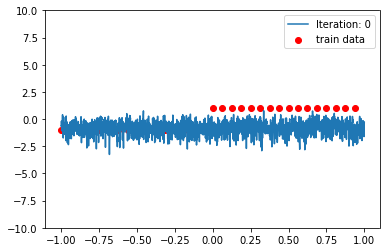

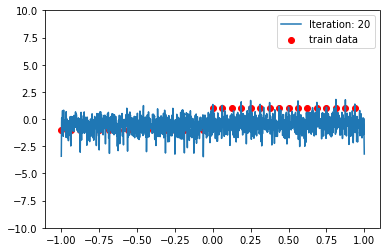

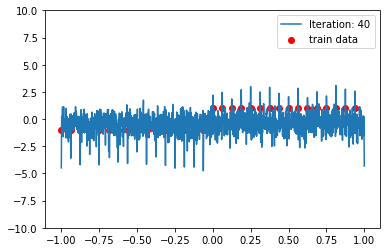

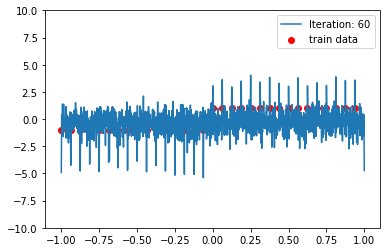

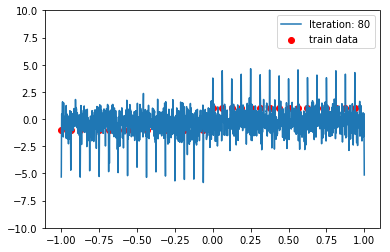

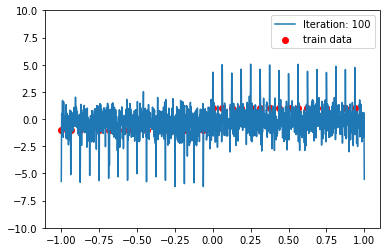

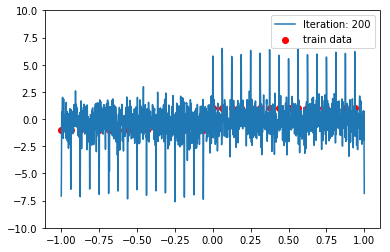

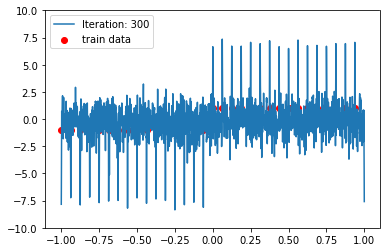

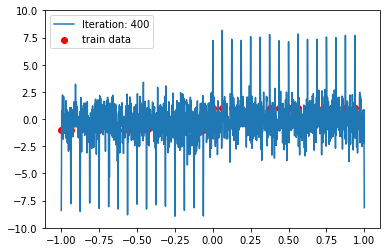

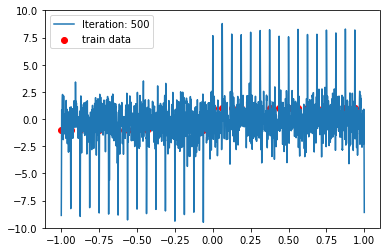

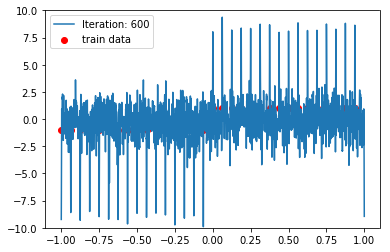

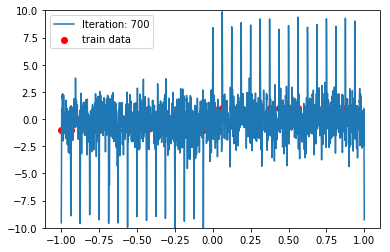

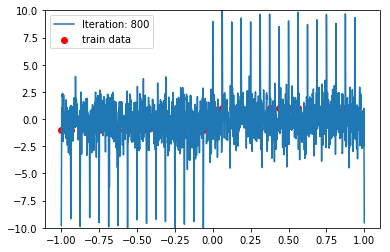

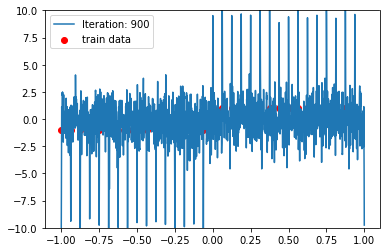

In [30]:
#plt.plot(x_train, y_train_ogi.flatten(),  color = "blue", linewidth=0, marker="D", markersize=5, label = 'Train data', alpha = 0.75 )

for (idx, preds) in enumerate(preds_list_smaller):
    label = "Iteration: " + str(indices[idx])
    plt.scatter(x_train, y_train_ogi, label = 'train data', color = 'red')
    plt.plot(x_test, preds,'-', marker = 'x', markersize = 0, linewidth = 1.5, label = label)
    plt.ylim([-10,10])
    plt.legend()
    plt.show()

# Processing feats and plotting

In [31]:
feats_select = feat_list[-1]

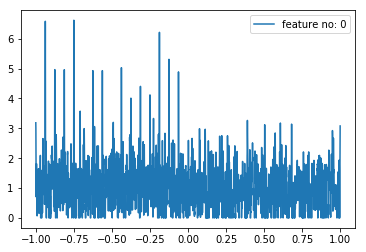

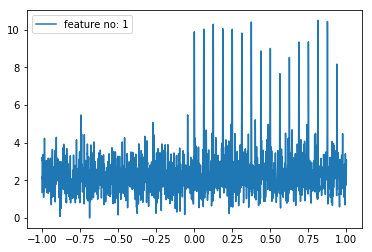

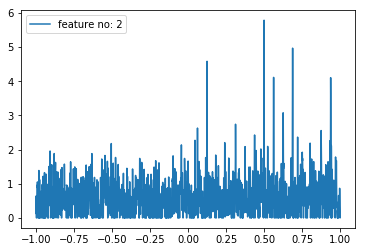

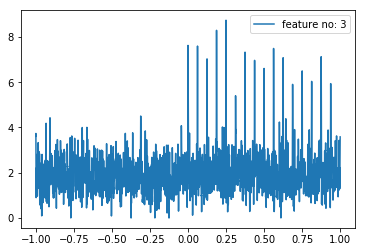

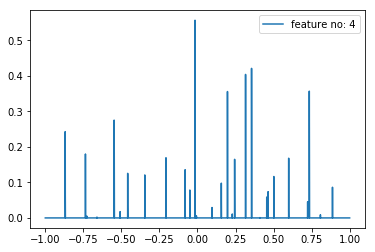

In [32]:
for i in range(5):
    feat_i = feats_select[:, i]
    label = "feature no: " + str(i)
    plt.plot(x_test, feat_i, label = label)
    plt.legend()
    plt.show()